In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels

In [2]:
path = 'https://raw.githubusercontent.com/CathyChen532/QM-Group-20/main/combined_selected_data.csv'
df = pd.read_csv(path)

In [3]:
# check some example numbers
df.head()

,Code,Area,Highly satisfy with life (rate),Life expectancy (age),NVQ4+ leve of working age population (16-64) (percent),median of personal incomes by tax year
0,E09000001,City of London,NaN,NaN,80.0,61100
1,E09000002,Barking and Dagenham,73.65,77.8,32.4,21800
2,E09000003,Barnet,79.83,82.2,49.1,27100
3,E09000004,Bexley,77.88,80.0,33.6,24400
4,E09000005,Brent,82.78,80.3,45.1,22700


In [4]:
# print the shape of the DataFrame
df.shape

(33, 6)

In [5]:
# print the column names
df.columns

Index(['Code', 'Area', 'Highly satisfy with life (rate)',
       'Life expectancy (age)',
       'NVQ4+ leve of working age population (16-64) (percent)',
       'median of personal incomes by tax year'],
      dtype='object')

In [6]:
# rename columns
df_rename = df.rename(columns = {'Highly satisfy with life (rate)':'satisfy',
                          'Life expectancy (age)':'expectancy',
                          'NVQ4+ leve of working age population (16-64) (percent)':'education',
                          'median of personal incomes by tax year':'income'})
print(df.columns)

Index(['Code', 'Area', 'Highly satisfy with life (rate)',
       'Life expectancy (age)',
       'NVQ4+ leve of working age population (16-64) (percent)',
       'median of personal incomes by tax year'],
      dtype='object')


In [7]:
# pick the columns that we need
df_pick = df_rename.loc[:,['satisfy', 'expectancy', 'education', 'income']]

df_pick.columns

Index(['satisfy', 'expectancy', 'education', 'income'], dtype='object')

In [8]:
# check datatype
df_pick.dtypes

satisfy       float64
expectancy    float64
education     float64
income          int64
dtype: object

In [9]:
# change datatype
df_pick['income'] = pd.to_numeric(df_pick['income'], downcast='float')

df_pick.dtypes

satisfy       float64
expectancy    float64
education     float64
income        float32
dtype: object

<AxesSubplot:xlabel='income', ylabel='expectancy'>

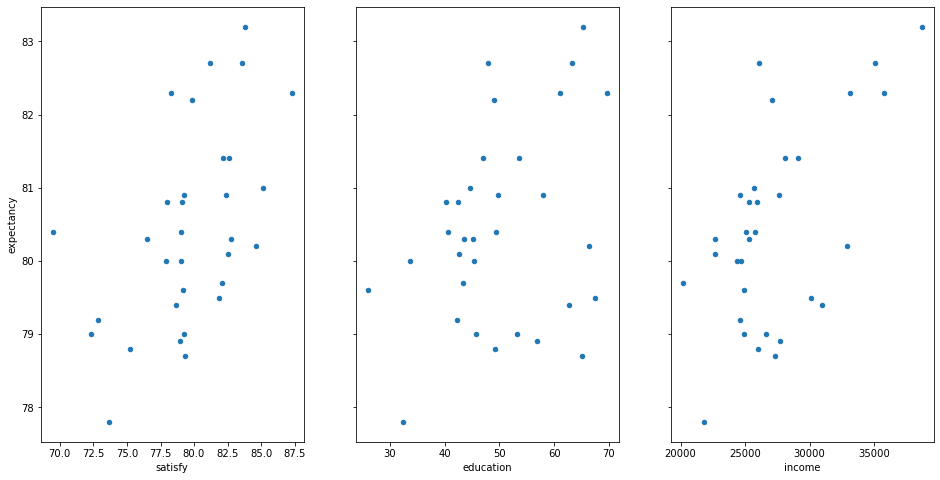

In [10]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3, sharey=True)
df_pick.plot(kind='scatter', x='satisfy', y='expectancy', ax=axs[0], figsize=(16, 8))
df_pick.plot(kind='scatter', x='education', y='expectancy', ax=axs[1])
df_pick.plot(kind='scatter', x='income', y='expectancy', ax=axs[2])

In [11]:
df_pick.corr()

,satisfy,expectancy,education,income
satisfy,1.000000,0.525483,0.363571,0.405041
expectancy,0.525483,1.000000,0.320484,0.579743
education,0.363571,0.320484,1.000000,0.763065
income,0.405041,0.579743,0.763065,1.000000


In [12]:
# This performs a multiple regression of expectancy against recycling:

reg_exp = smf.ols(formula='expectancy ~ satisfy + education + income',data=df_pick).fit()

# And this gives a big summary of the results:
print(reg_exp.summary())

                            OLS Regression Results                            
Dep. Variable:             expectancy   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     9.277
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           0.000201
Time:                        01:47:12   Log-Likelihood:                -43.102
No. Observations:                  32   AIC:                             94.20
Df Residuals:                      28   BIC:                             100.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.4240      3.660     18.151      0.0

In [13]:
# conditional number is large, so calculating VIF to check are there strong multicollinearity
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df_pick, thresh=5):
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_pick_with_const = add_constant(df_pick)

        vif_df_pick = pd.Series([variance_inflation_factor(df_pick_with_const.values, i) 
               for i in range(df_pick_with_const.shape[1])], name= "VIF",
              index=df_pick_with_const.columns).to_frame()

        # drop the const
        vif_df_pick = vif_df_pick.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df_pick.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df_pick.index[vif_df_pick.VIF == vif_df_pick.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df_pick = df_pick.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df_pick

In [14]:
# delete inf and nan
df_pick[np.isnan(df_pick)] = 0
df_pick[np.isinf(df_pick)] = 0

df_pick.head()

,satisfy,expectancy,education,income
0,0.00,0.0,80.0,61100.0
1,73.65,77.8,32.4,21800.0
2,79.83,82.2,49.1,27100.0
3,77.88,80.0,33.6,24400.0
4,82.78,80.3,45.1,22700.0


In [15]:
# drop columns that are strong multicollinearity
df_drop = drop_column_using_vif_(df_pick.drop('expectancy', axis=1))

df_drop.head()

Dropping: income


,satisfy,education
0,0.00,80.0
1,73.65,32.4
2,79.83,49.1
3,77.88,33.6
4,82.78,45.1


In [16]:
#fit a linear regression model
import statsmodels.api as sm

life_expect = sm.OLS(endog=df_pick[['expectancy']], exog=sm.add_constant(df_drop)).fit()
life_expect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             expectancy   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     304.2
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           1.21e-20
Time:                        01:47:23   Log-Likelihood:                -83.104
No. Observations:                  33   AIC:                             172.2
Df Residuals:                      30   BIC:                             176.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7245      4.682      2.718      0.011       3.162      22.287
satisfy        0.9192      0.041     22.422      0.000       0.835       1.003
education     -0.1117      0.049     -2.264      0.031      -0.212      -0.011
==============================================================================
Omnibus:                        7.689   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                6.125
Skew:                           0.894   Prob(JB):                       0.0468
Kurtosis:                       4.122   Cond. No.                         797.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""